In [1]:
#Define functions for computing ARI from GEV prameters

from scw_compare import get_era5_lsm
from percent_mean_change import transform_from_latlon
import matplotlib.pyplot as plt
import geopandas
import pandas as pd
from rasterio import features
from affine import Affine
import glob
import xarray as xr
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import genextreme
from tqdm import tqdm
import netCDF4 as nc
from ari import drop_duplicates, get_barra_mask, get_barra_topog
from scw_compare import rasterize
import pandas as pd
import numpy as np

def compute_gev(da, ari):
    '''
        From an xarray dataarray with variables containing shape, location and scale parameters for a GEV, return the values for a given ari
    '''
    
    n, m = da.c.shape
    out = np.zeros((n,m))
    c = da.c.values
    loc = da["loc"].values
    scale = da.scale.values
    p = 1 - (1 / ari)
    for i in tqdm(np.arange(n)):
        for j in (np.arange(m)):
                   out[i,j] = genextreme.isf(q=1-p, c=c[i,j], loc=loc[i,j], scale=scale[i,j])
                   
    return out

def compute_lmom_gev_nrm(da):
    '''
        From the NRM-maximum annual time series-fitted GEV, compute the ARI
    '''
    T = (np.logspace(-1,3,1000))
    out =  [ genextreme.isf(q=1-(1-(1/T)), c=da.attrs["c_lmom_nrm"][i], loc=da.attrs["loc_lmom_nrm"][i], scale=da.attrs["scale_lmom_nrm"][i]) for i in np.arange(4) ]
    return [out, T]   

def compute_gev_nrm(da):
    '''
        From the NRM-maximum annual time series-fitted GEV, compute the ARI
    '''
    T = (np.logspace(-1,3,1000))
    out =  [ genextreme.isf(q=1-(1-(1/T)), c=da.attrs["nrm_c"][i], loc=da.attrs["nrm_loc"][i], scale=da.attrs["nrm_scale"][i]) for i in np.arange(4) ]
    return [out, T]   

def compute_lmom_gev(da, ari):
    '''
        From an xarray dataarray with variables containing shape, location and scale parameters for a GEV, return the values for a given ari
    '''
    
    n, m = da.c_lmom.shape
    out = np.zeros((n,m))
    c = da.c_lmom.values
    loc = da["loc_lmom"].values
    scale = da.scale_lmom.values
    p = 1 - (1 / ari)
    for i in tqdm(np.arange(n)):
        for j in (np.arange(m)):
                   out[i,j] = genextreme.isf(q=1-p, c=c[i,j], loc=loc[i,j], scale=scale[i,j])
                   
    return out

def plot_borders(nrm_da):
    #xr.plot.contourf(xr.where(nrm_da==2, 1, 0), levels=[0.5,1.5], colors=["none","none"], add_labels=False, hatches=["","/"], alpha=0, add_colorbar=False)
    xr.plot.contour(xr.where(nrm_da==2, 1, 0), levels=[0.5,1.5], linestyles="dashed", colors=["k"], add_labels=False)
    #[xr.plot.contour(xr.where((nrm_da==i) & (~(nrm_da["aus"].isnull())), 1, 0), levels=[0.5,1.5], colors="k", add_labels=False) for i in [0,1,2,3]]

def get_nrm(temp):
    #temp = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/ERA5__mean_lr36_historical_1979_2005.nc")
    f = geopandas.read_file("/home/548/ab4502/NRM_super_clusters/NRM_super_clusters.shp")
    f2 = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
    shapes = [(shape, n) for n, shape in enumerate(f.geometry)]
    nrm_da = rasterize(shapes, {"lon":temp.lon,"lat":temp.lat})
    nrm_da["aus"] = rasterize([f2.loc[f2.name=="Australia"].geometry.values[0]], {"lon":temp.lon,"lat":temp.lat})
    return nrm_da

In [2]:
#Load data and compute ARI

y1=1990; y2=2018; ari=10
path = "/g/data/eg3/ab4502/gev/"
annmaxstr="_annmax"
barra_gev = xr.open_dataset(path+"barra_gev_"+str(y1)+"_"+str(y2)+".nc")
barra_cdf = xr.open_dataset(path+"barra_cdf_"+str(y1)+"_"+str(y2)+annmaxstr+".nc")
barra_cdf_nrm = [ pd.read_csv(path+"barra_cdf_"+str(y1)+"_"+str(y2)+"_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]
barra_max = xr.open_dataset(path+"barra_cdf_"+str(y1)+"_"+str(y2)+".nc")
barra_sy_gev = xr.open_dataset(path+"barra_sy_gev_"+str(y1)+"_"+str(y2)+".nc")
barra_sy_cdf = xr.open_dataset(path+"barra_sy_cdf_"+str(y1)+"_"+str(y2)+".nc")
barra_sy_max = xr.open_dataset(path+"barra_sy_cdf_"+str(y1)+"_"+str(y2)+".nc")
barra_sy_cdf_nrm = [ pd.read_csv(path+"barra_sy_cdf_"+str(y1)+"_"+str(y2)+"_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]
barpa_gev = xr.open_dataset(path+"barpa_access_gev_"+str(y1)+"_"+str(y2)+".nc")
barpa_cdf = xr.open_dataset(path+"barpa_access_cdf_"+str(y1)+"_"+str(y2)+".nc")
barpa_max = xr.open_dataset(path+"barpa_access_cdf_"+str(y1)+"_"+str(y2)+".nc")
barpa_cdf_nrm = [ pd.read_csv(path+"barpa_access_cdf_"+str(y1)+"_"+str(y2)+"_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]
era5_gev = xr.open_dataset(path+"era5_gev_"+str(y1)+"_"+str(y2)+".nc")
era5_cdf = xr.open_dataset(path+"era5_cdf_"+str(y1)+"_"+str(y2)+".nc")
era5_max = xr.open_dataset(path+"era5_cdf_"+str(y1)+"_"+str(y2)+".nc")
era5_cdf_nrm = [ pd.read_csv(path+"era5_cdf_"+str(y1)+"_"+str(y2)+"_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]

barra_ari = compute_gev(barra_gev, ari)
barra_ari_nrm, T = compute_gev_nrm(barra_gev)
barra_lmom_ari = compute_lmom_gev(barra_gev, ari)
barra_ari_lmom_nrm, T = compute_lmom_gev_nrm(barra_gev)

barra_sy_ari = compute_gev(barra_sy_gev, ari)
barra_sy_nrm, T = compute_gev_nrm(barra_sy_gev)
barra_sy_lmom_ari = compute_lmom_gev(barra_sy_gev, ari)
barra_sy_lmom_nrm, T = compute_lmom_gev_nrm(barra_sy_gev)

barpa_ari = compute_gev(barpa_gev, ari)
barpa_nrm, T = compute_gev_nrm(barpa_gev)
barpa_lmom_ari = compute_lmom_gev(barpa_gev, ari)
barpa_lmom_nrm, T = compute_lmom_gev_nrm(barpa_gev)

era5_ari = compute_gev(era5_gev, ari)
era5_nrm, T = compute_gev_nrm(era5_gev)
era5_lmom_ari = compute_lmom_gev(era5_gev, ari)
era5_lmom_nrm, T = compute_lmom_gev_nrm(era5_gev)


100%|██████████| 139/139 [00:04<00:00, 32.28it/s]


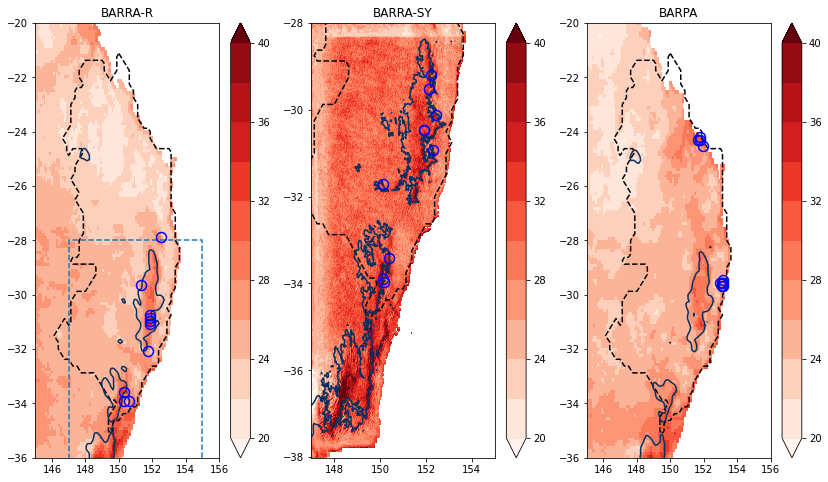

In [3]:
#Plot spatial map of 10 year ARI

era5_range = [10,60]
barra_range = [20,40]
cmap = plt.get_cmap("Reds")
levels = 11
rows=5
cols=8

nrm_da = get_nrm(xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/ERA5__mean_lr36_historical_1979_2005.nc"))

plt.figure(figsize=[14,8])
#BARRA GEV LMOM
plt.subplot(1,3,1)
lsm_r = get_barra_mask(barra_gev.lon.values, barra_gev.lat.values)
topog = get_barra_topog(barra_gev.lon.values, barra_gev.lat.values)
xr.DataArray(data=np.where((barra_gev.lmom_fail==0) & (lsm_r==1), barra_lmom_ari, np.nan), coords=(barra_gev.lat, barra_gev.lon)).\
    plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", xlim=[145, 156], ylim=[-36, -20], add_colorbar=True)
plot_borders(nrm_da)
xr.plot.contour(xr.DataArray(data=topog, coords=(barra_gev.lat, barra_gev.lon)), xlim=[145,\
    156], ylim=[-36, -20], levels=[750])
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")
plt.title("BARRA-R")

x1=barra_sy_gev.lon.min()
x2=barra_sy_gev.lon.max()
y1=barra_sy_gev.lat.min()
y2=barra_sy_gev.lat.max()
plt.plot([x1,x1,x2,x2,x1], [y1,y2,y2,y1,y1], color="tab:blue", linestyle="--")

x=xr.where((lsm_r==1) & (nrm_da.interp_like(barra_gev)==2), barra_max["max"], np.nan).values.flatten()
x=x[~np.isnan(x)]
q = (np.sort(x)[-10:])
a = xr.where((lsm_r==1) & (nrm_da.interp_like(barra_gev)==2), barra_max["max"], np.nan)
x,y=np.meshgrid(barra_gev.lon, barra_gev.lat)
lons=xr.where(a>=q[0], x, np.nan).values
lons=lons[~np.isnan(lons)]
lats=xr.where(a>=q[0], y, np.nan).values
lats=lats[~np.isnan(lats)]
plt.plot(lons, lats, marker="o", color="b", ms=10, mew=1.5, linestyle="none", mfc="none")

#BARRA-SY GEV LMOM
plt.subplot(1,3,2)
topog = xr.open_dataset("/g/data/ma05/BARRA_SY/v1/static/topog-fc-slv-PT0H-BARRA_SY-v1.nc")["topog"]
lsm_sy = ((topog.values) > 0) * 1
xr.DataArray(data=np.where((barra_sy_gev.lmom_fail==0) & (lsm_sy==1), barra_sy_lmom_ari, np.nan), coords=(barra_sy_gev.lat, barra_sy_gev.lon)).plot(vmin=barra_range[0],
        vmax=barra_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da)
xr.plot.contour(topog, levels=[750], add_labels=False)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")
plt.title("BARRA-SY")

x=xr.where((lsm_sy==1) & (nrm_da.interp_like(barra_sy_gev)==2), barra_sy_max["max"], np.nan).values.flatten()
x=x[~np.isnan(x)]
q = (np.sort(x)[-10:])
a = xr.where((lsm_sy==1) & (nrm_da.interp_like(barra_sy_gev)==2), barra_sy_max["max"], np.nan)
x,y=np.meshgrid(barra_sy_gev.lon, barra_sy_gev.lat)
lons=xr.where(a>=q[0], x, np.nan).values
lons=lons[~np.isnan(lons)]
lats=xr.where(a>=q[0], y, np.nan).values
lats=lats[~np.isnan(lats)]
plt.plot(lons, lats, marker="o", color="b", ms=10, mew=1.5, linestyle="none", mfc="none")

#BARPA-SY GEV LMOM
plt.subplot(1,3,3)
topog = xr.open_dataset("/g/data/du7/barpa/trials/BARPA-EASTAUS_12km/static/topog-BARPA-EASTAUS_12km.nc")["topog"].interp({"latitude":barpa_gev.lat, "longitude":barpa_gev.lon}, "nearest")
lsm_barp = ((topog.values) > 0) * 1
xr.DataArray(data=np.where((barpa_gev.lmom_fail==0) & (lsm_barp==1), barpa_lmom_ari, np.nan), coords=(barpa_gev.lat, barpa_gev.lon)).plot(vmin=barra_range[0],
        vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", xlim=[145, 156], ylim=[-36, -20])
plot_borders(nrm_da)
xr.plot.contour(topog, levels=[750], add_labels=False)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")
plt.title("BARPA")

x=xr.where((lsm_barp==1) & (nrm_da.interp_like(barpa_gev)==2), barpa_max["max"], np.nan).values.flatten()
x=x[~np.isnan(x)]
q = (np.sort(x)[-10:])
a = xr.where((lsm_barp==1) & (nrm_da.interp_like(barpa_gev)==2), barpa_max["max"], np.nan)
x,y=np.meshgrid(barpa_gev.lon, barpa_gev.lat)
lons=xr.where(a>=q[0], x, np.nan).values
lons=lons[~np.isnan(lons)]
lats=xr.where(a>=q[0], y, np.nan).values
lats=lats[~np.isnan(lats)]
plt.plot(lons, lats, marker="o", color="b", ms=10, mew=1.5, linestyle="none", mfc="none")


plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/ari10_annual.png", bbox_inches="tight")

#plt.figure()
#i=2
#labs = ["Nth. Aus.", "Rangelands", "East Aus.", "Sth. Aus."]
#plt.plot(T, barra_ari_lmom_nrm[i], color="tab:blue", label="BARRA")
#plt.plot(barra_cdf_nrm[i]["T"], barra_cdf_nrm[i]["wind_speed"], color="k", linestyle="--", marker="x")
#plt.plot(T, barra_sy_lmom_nrm[i], color="tab:red", label="BARRA")
#plt.plot(barra_sy_cdf_nrm[i]["T"], barra_sy_cdf_nrm[i]["wind_speed"], color="k", linestyle="--", marker="x")
#plt.xscale("log")
#plt.xticks(ticks=[1,10,100])
#plt.xlim([1,200])
#plt.text(1, plt.gca().get_ylim()[1]*0.99, labs[i], va="top", fontdict={"size":10})
#plt.gca().set_ylabel("Annual-Eastern Australia \nmaximum \nwind gust (m/s)",fontdict={"size":14})
#plt.gca().set_xlabel("Return period (years)",fontdict={"size":14})
#plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/ari_annual.png", bbox_inches="tight")

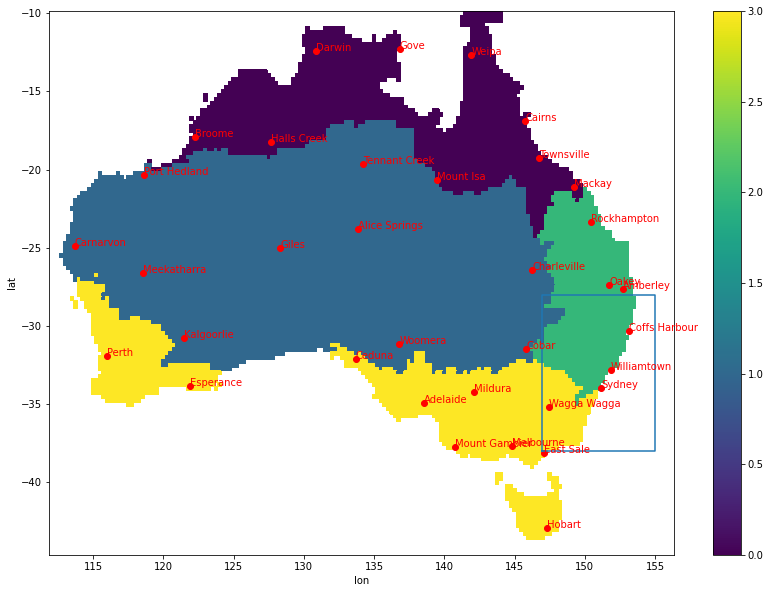

In [5]:
#Load AWS station information and data, plot stations

names = ["id", "stn_no", "district", "stn_name", "1", "2", "lat", "lon", "3", "4", "5", "6", "7", "8", \
"9", "10", "11", "12", "13", "14", "15", "16"]	
df = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/obs/aws/daily_aus_full/DC02D_StnDet_999999999643799.txt",\
names=names, header=0)
renames = {'ALICE SPRINGS AIRPORT                   ':"Alice Springs",\
'GILES METEOROLOGICAL OFFICE             ':"Giles",\
'COBAR MO                                ':"Cobar",\
'AMBERLEY AMO                            ':"Amberley",\
'SYDNEY AIRPORT AMO                      ':"Sydney",\
'MELBOURNE AIRPORT                       ':"Melbourne",\
'MACKAY M.O                              ':"Mackay",\
'WEIPA AERO                              ':"Weipa",\
'MOUNT ISA AERO                          ':"Mount Isa",\
'ESPERANCE                               ':"Esperance",\
'ADELAIDE AIRPORT                        ':"Adelaide",\
'CHARLEVILLE AERO                        ':"Charleville",\
'CEDUNA AMO                              ':"Ceduna",\
'OAKEY AERO                              ':"Oakey",\
'WOOMERA AERODROME                       ':"Woomera",\
'TENNANT CREEK AIRPORT                   ':"Tennant Creek",\
'GOVE AIRPORT                            ':"Gove",\
'COFFS HARBOUR MO                        ':"Coffs Harbour",\
'MEEKATHARRA AIRPORT                     ':"Meekatharra",\
'HALLS CREEK METEOROLOGICAL OFFICE       ':"Halls Creek",\
'ROCKHAMPTON AERO                        ':"Rockhampton",\
'MOUNT GAMBIER AERO                      ':"Mount Gambier",\
'PERTH AIRPORT                           ':"Perth",\
'WILLIAMTOWN RAAF                        ':"Williamtown",\
'CARNARVON AIRPORT                       ':"Carnarvon",\
'KALGOORLIE-BOULDER AIRPORT              ':"Kalgoorlie",\
'DARWIN AIRPORT                          ':"Darwin",\
'CAIRNS AERO                             ':"Cairns",\
'MILDURA AIRPORT                         ':"Mildura",\
'WAGGA WAGGA AMO                         ':"Wagga Wagga",\
'BROOME AIRPORT                          ':"Broome",\
'EAST SALE                               ':"East Sale",\
'TOWNSVILLE AERO                         ':"Townsville",\
'HOBART (ELLERSLIE ROAD)                 ':"Hobart",\
'PORT HEDLAND AIRPORT                    ':"Port Hedland"}
df = df.replace({"stn_name":renames})
points = [(df.lon.iloc[i], df.lat.iloc[i]) for i in np.arange(df.shape[0])]
temp = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/ERA5__mean_lr36_historical_1979_2005.nc")
f = geopandas.read_file("/home/548/ab4502/NRM_super_clusters/NRM_super_clusters.shp")
f2 = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
shapes = [(shape, n) for n, shape in enumerate(f.geometry)]
nrm_da = rasterize(shapes, {"lon":temp.lon,"lat":temp.lat})
nrm_da["aus"] = rasterize([f2.loc[f2.name=="Australia"].geometry.values[0]], {"lon":temp.lon,"lat":temp.lat})
names = ["record_id","stn_no","stn_name","locality", "state","lat","lon","height","date_str",\
                "wind_gust","quality","wind_dir", "wind_dir_quality", "max_gust_str_lt", \
                "max_gust_time_quality", "eof"]
data_types = dict(record_id=str, stn_no=int, stn_name=str, locality=str, state=str, lat=float, lon=float,\
                                height=str, date_str=str, wind_gust=float, quality=str, \
                                wind_dir=str, wind_dir_quality=str, max_gust_str_lt=str,\
                                max_gust_time_quality=str,\
                                eof=str)
f = "/g/data/eg3/ab4502/ExtremeWind/obs/aws/daily_aus_full/DC02D_Data_999999999720188.txt"
obs = pd.read_csv(f, names=names, dtype=data_types, na_values={"wind_gust":'     ', "max_gust_str_lt":"    "})
obs = obs.replace({"stn_name":renames})
obs["wind_dir"] = obs["wind_dir"].str.strip()
obs["wind_dir"] = pd.to_numeric(obs.wind_dir, errors="coerce")
obs["stn_name"] = obs["stn_name"].str.strip()
obs["year"] = obs.date_str.str.slice(6,10).astype("int")
obs["month"] = obs.date_str.str.slice(3,5).astype("int")
obs["day_lt"] = obs.date_str.str.slice(0,2).astype("int")
obs["daily_date_lt"] = pd.to_datetime({"year":obs["year"],"month":obs["month"],"day":obs["day_lt"]})
fig = plt.figure(figsize=[14,10])
ax = plt.gca()
nrm_da.plot(ax=ax)
for i in np.arange(len(points)):
    x, y = points[i]
    n = df.iloc[i]["stn_name"]
    ax.text(x, y, n, color="red")
    ax.plot(x,y,marker="o",color="red")
x1=barra_sy_gev.lon.min()
x2=barra_sy_gev.lon.max()
y1=barra_sy_gev.lat.min()
y2=barra_sy_gev.lat.max()
plt.plot([x1,x1,x2,x2,x1], [y1,y2,y2,y1,y1], color="tab:blue")
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/stn_map.png", bbox_inches="tight")

In [6]:
#Plot ARI comparison between BARRA, BARPA and station data

stn_lon = df[df.stn_name=="Sydney"]["lon"]
stn_lat = df[df.stn_name=="Sydney"]["lat"]

#BARRA-SY
a,b = np.meshgrid(barra_sy_gev.lon, barra_sy_gev.lat)
a[lsm_sy==0] = np.nan
b[lsm_sy==0] = np.nan
dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

c = barra_sy_gev["c"].isel({"lat":temp_lat, "lon":temp_lon})
loc = barra_sy_gev["loc"].isel({"lat":temp_lat, "lon":temp_lon})
scale = barra_sy_gev["scale"].isel({"lat":temp_lat, "lon":temp_lon})
p = np.linspace(0,1,10000)
T = 1/(1-p)
x = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))
x_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barra_sy_annmax_annual_1990_2018.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
T_raw = (1 / (1 - ECDF(x4_raw).y))

#BARRA
a,b = np.meshgrid(barra_gev.lon, barra_gev.lat)
a[lsm_r==0] = np.nan
b[lsm_r==0] = np.nan
dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

c = barra_gev["c"].isel({"lat":temp_lat, "lon":temp_lon})
loc = barra_gev["loc"].isel({"lat":temp_lat, "lon":temp_lon})
scale = barra_gev["scale"].isel({"lat":temp_lat, "lon":temp_lon})
p = np.linspace(0,1,10000)
T = 1/(1-p)
x2 = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))

#BARPA
topog = xr.open_dataset("/g/data/du7/barpa/trials/BARPA-EASTAUS_12km/static/topog-BARPA-EASTAUS_12km.nc")["topog"].interp({"latitude":barpa_gev.lat, "longitude":barpa_gev.lon}, "nearest")
lsm_barp = ((topog.values) > 0) * 1
a,b = np.meshgrid(barpa_gev.lon, barpa_gev.lat)
a[lsm_barp==0] = np.nan
b[lsm_barp==0] = np.nan
dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

c = barpa_gev["c_lmom"].isel({"lat":temp_lat, "lon":temp_lon})
loc = barpa_gev["loc_lmom"].isel({"lat":temp_lat, "lon":temp_lon})
scale = barpa_gev["scale_lmom"].isel({"lat":temp_lat, "lon":temp_lon})
x4_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_1990_2018.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
T4 = (1 / (1 - ECDF(x4_raw).y))
p = np.linspace(0,1,10000)
T = 1/(1-p)
x4 = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))

#ERA5
topog = xr.open_dataset("/g/data/ub4/era5/netcdf/static_era5.nc")["lsm"].interp({"latitude":era5_gev.lat, "longitude":era5_gev.lon}, "nearest")
lsm_era5 = (np.squeeze(topog.values) > 0) * 1
a,b = np.meshgrid(era5_gev.lon, era5_gev.lat)
a[lsm_era5==0] = np.nan#
b[lsm_era5==0] = np.nan
dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

c = era5_gev["c_lmom"].isel({"lat":temp_lat, "lon":temp_lon})
loc = era5_gev["loc_lmom"].isel({"lat":temp_lat, "lon":temp_lon})
scale = era5_gev["scale_lmom"].isel({"lat":temp_lat, "lon":temp_lon})
p = np.linspace(0,1,10000)
T = 1/(1-p)
x5 = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))

#OBS
x3 = np.sort(obs[obs.stn_name=="Sydney"][["daily_date_lt", "wind_gust"]].iloc[:-1].resample("1Y", on="daily_date_lt").max()["wind_gust"].values)
T3 = (1 / (1 - ECDF(x3).y))

plt.plot(T, x, label="BARRA-SY")
plt.plot(T_raw[:-1],raw, x_raw, marker="x", linestyle="none", color="tab:blue")
plt.plot(T, x2, label="BARRA-R")
plt.plot(T, x4, color="tab:green", label="BARPA")
#plt.plot(T, x5, color="tab:red", label="ERA5")
plt.plot(T4[:-1], x4_raw, marker="x",linestyle="none", color="tab:green")
plt.plot(T3[:-1], x3, marker="x", color="k", linestyle="none", label="AWS")
plt.ylim([20,50])
plt.xlim([1,200])
plt.xscale("log")
plt.title("Sydney AP")
#plt.legend()
ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel("Return period (years)", size=14)
plt.ylabel("10 m wind gust (m/s)", size=14)
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/ari_sydneyAP.png", bbox_inches="tight")

/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


NameError: name 'x4_raw' is not defined

/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide


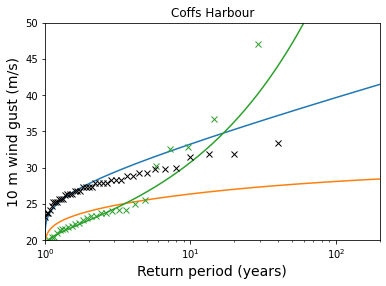

In [7]:
stn_lon = df[df.stn_name=="Coffs Harbour"]["lon"]
stn_lat = df[df.stn_name=="Coffs Harbour"]["lat"]

a,b = np.meshgrid(barra_sy_gev.lon, barra_sy_gev.lat)
a[lsm_sy==0] = np.nan
b[lsm_sy==0] = np.nan
dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

c = barra_sy_gev["c"].isel({"lat":temp_lat, "lon":temp_lon})
loc = barra_sy_gev["loc"].isel({"lat":temp_lat, "lon":temp_lon})
scale = barra_sy_gev["scale"].isel({"lat":temp_lat, "lon":temp_lon})
p = np.linspace(0,1,10000)
T = 1/(1-p)
x = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))

a,b = np.meshgrid(barra_gev.lon, barra_gev.lat)
a[lsm_r==0] = np.nan
b[lsm_r==0] = np.nan
dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

c = barra_gev["c"].isel({"lat":temp_lat, "lon":temp_lon})
loc = barra_gev["loc"].isel({"lat":temp_lat, "lon":temp_lon})
scale = barra_gev["scale"].isel({"lat":temp_lat, "lon":temp_lon})
p = np.linspace(0,1,10000)
T = 1/(1-p)
x2 = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))


#BARPA
topog = xr.open_dataset("/g/data/du7/barpa/trials/BARPA-EASTAUS_12km/static/topog-BARPA-EASTAUS_12km.nc")["topog"].interp({"latitude":barpa_gev.lat, "longitude":barpa_gev.lon}, "nearest")
lsm_barp = ((topog.values) > 0) * 1
a,b = np.meshgrid(barpa_gev.lon, barpa_gev.lat)
a[lsm_barp==0] = np.nan
b[lsm_barp==0] = np.nan
dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

c = barpa_gev["c"].isel({"lat":temp_lat, "lon":temp_lon})
loc = barpa_gev["loc"].isel({"lat":temp_lat, "lon":temp_lon})
scale = barpa_gev["scale"].isel({"lat":temp_lat, "lon":temp_lon})
x4_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_1990_2018.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
T4 = (1 / (1 - ECDF(x4_raw).y))
p = np.linspace(0,1,10000)
T = 1/(1-p)
x4 = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))

#ERA5
topog = xr.open_dataset("/g/data/ub4/era5/netcdf/static_era5.nc")["lsm"].interp({"latitude":era5_gev.lat, "longitude":era5_gev.lon}, "nearest")
lsm_era5 = (np.squeeze(topog.values) > 0) * 1
a,b = np.meshgrid(era5_gev.lon, era5_gev.lat)
a[lsm_era5==0] = np.nan
b[lsm_era5==0] = np.nan
dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

c = era5_gev["c_lmom"].isel({"lat":temp_lat, "lon":temp_lon})
loc = era5_gev["loc_lmom"].isel({"lat":temp_lat, "lon":temp_lon})
scale = era5_gev["scale_lmom"].isel({"lat":temp_lat, "lon":temp_lon})
p = np.linspace(0,1,10000)
T = 1/(1-p)
x5 = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))

x3 = np.sort(obs[obs.stn_name=="Sydney"][["daily_date_lt", "wind_gust"]].iloc[:-1].resample("1Y", on="daily_date_lt").max()["wind_gust"].values)
T3 = (1 / (1 - ECDF(x3).y))

plt.plot(T, x, label="BARRA-SY")
plt.plot(T, x2, label="BARRA-R")
plt.plot(T, x4, color="tab:green", label="BARPA")
#plt.plot(T, x5, color="tab:red", label="ERA5")
plt.plot(T4[:-1], x4_raw, marker="x",linestyle="none", color="tab:green")
plt.plot(T3[:-1], x3, marker="x", color="k", linestyle="none")
plt.ylim([20,50])
plt.xlim([1,200])
plt.xscale("log")
plt.title("Coffs Harbour")
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel("Return period (years)", size=14)
plt.ylabel("10 m wind gust (m/s)", size=14)
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/ari_coffs_harbour.png", bbox_inches="tight")

In [4]:
stn_lon = df[df.stn_name=="Williamtown"]["lon"]
stn_lat = df[df.stn_name=="Williamtown"]["lat"]

a,b = np.meshgrid(barra_sy_gev.lon, barra_sy_gev.lat)
a[lsm_sy==0] = np.nan
b[lsm_sy==0] = np.nan
dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

c = barra_sy_gev["c_lmom"].isel({"lat":temp_lat, "lon":temp_lon})
loc = barra_sy_gev["loc_lmom"].isel({"lat":temp_lat, "lon":temp_lon})
scale = barra_sy_gev["scale_lmom"].isel({"lat":temp_lat, "lon":temp_lon})
p = np.linspace(0,1,10000)
T = 1/(1-p)
x = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))

a,b = np.meshgrid(barra_gev.lon, barra_gev.lat)
a[lsm_r==0] = np.nan
b[lsm_r==0] = np.nan
dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

c = barra_gev["c_lmom"].isel({"lat":temp_lat, "lon":temp_lon})
loc = barra_gev["loc_lmom"].isel({"lat":temp_lat, "lon":temp_lon})
scale = barra_gev["scale_lmom"].isel({"lat":temp_lat, "lon":temp_lon})
p = np.linspace(0,1,10000)
T = 1/(1-p)
x2 = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))

#BARPA
topog = xr.open_dataset("/g/data/du7/barpa/trials/BARPA-EASTAUS_12km/static/topog-BARPA-EASTAUS_12km.nc")["topog"].interp({"latitude":barpa_gev.lat, "longitude":barpa_gev.lon}, "nearest")
lsm_barp = ((topog.values) > 0) * 1
a,b = np.meshgrid(barpa_gev.lon, barpa_gev.lat)
a[lsm_barp==0] = np.nan
b[lsm_barp==0] = np.nan
dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

c = barpa_gev["c_lmom"].isel({"lat":temp_lat, "lon":temp_lon})
loc = barpa_gev["loc_lmom"].isel({"lat":temp_lat, "lon":temp_lon})
scale = barpa_gev["scale_lmom"].isel({"lat":temp_lat, "lon":temp_lon})
x4_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_1990_2018.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
T4 = (1 / (1 - ECDF(x4_raw).y))
p = np.linspace(0,1,10000)
T = 1/(1-p)
x4 = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))


x3 = np.sort(obs[obs.stn_name=="Sydney"][["daily_date_lt", "wind_gust"]].iloc[:-1].resample("1Y", on="daily_date_lt").max()["wind_gust"].values)
T3 = (1 / (1 - ECDF(x3).y))

plt.plot(T, x, label="BARRA-SY GEV")
plt.plot(T, x2, label="BARRA-R GEV")
plt.plot(T, x4, label="BARPA GEV")
plt.plot(T4[:-1], x4_raw, marker="x",linestyle="none", color="tab:green")
plt.plot(T3[:-1], x3, marker="x", color="k", linestyle="none", label="AWS")
plt.ylim([20,45])
plt.xlim([1,200])
plt.xscale("log")
plt.title("Williamtown")
plt.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel("Return period (years)", size=14)
plt.ylabel("10 m wind gust (m/s)", size=14)
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/ari_williamtown.png", bbox_inches="tight")

NameError: name 'df' is not defined

In [9]:
stn_lon = df[df.stn_name=="Coffs Harbour"]["lon"]
stn_lat = df[df.stn_name=="Coffs Harbour"]["lat"]

a,b = np.meshgrid(barpa_gev.lon, barpa_gev.lat)
a[lsm_barp==0] = np.nan
b[lsm_barp==0] = np.nan
dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

print(pd.DataFrame({"gust":xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_1990_2018.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values, "year":xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_1990_2018.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).time.values}))
print(pd.DataFrame({"gust":xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_times_annual_1990_2018.nc")["annmax_times"].isel({"lat":temp_lat, "lon":temp_lon}).values}))

         gust       year
0   32.208008 1990-12-31
1   32.822266 1991-12-31
2   34.034180 1992-12-31
3   31.873047 1993-12-31
4   31.232422 1994-12-31
5   32.160156 1995-12-31
6   29.160156 1996-12-31
7   29.771484 1997-12-31
8   40.120117 1998-12-31
9   31.382812 1999-12-31
10  31.427734 2000-12-31
11  32.292969 2001-12-31
12  29.643555 2002-12-31
13  30.129883 2003-12-31
14  31.354492 2004-12-31
15  30.400391 2005-12-31
16  33.460938 2006-12-31
17  30.342773 2007-12-31
18  30.932617 2008-12-31
19  34.953125 2009-12-31
20  31.129883 2010-12-31
21  35.853516 2011-12-31
22  32.060547 2012-12-31
23  30.913086 2013-12-31
24  33.325195 2014-12-31
25  30.490234 2015-12-31
26  29.023438 2016-12-31
27  31.324219 2017-12-31
28  31.670898 2018-12-31
                  gust
0  1990-09-06 12:00:00
1  1991-08-22 12:00:00
2  1992-09-05 12:00:00
3  1993-06-16 12:00:00
4  1994-09-29 12:00:00
5  1995-08-12 12:00:00
6  1996-08-09 12:00:00
7  1997-07-17 12:00:00
8  1998-08-06 12:00:00
9  1999-01-13 12:00:

In [58]:
from ari import *
forcing_mdl="ACCESS1-0"
lat_bounds = [-44.525, -9.975]
lon_bounds = [111.975, 156.275]
years = np.arange(2004, 2004+1)
query_dates = date_seq([dt.datetime(2004,1,1,12), dt.datetime(2004,12,31,12)], "hours", 24)
files = np.sort(glob.glob("/g/data/du7/barpa/trials/BARPA-EASTAUS_12km/*/"+forcing_mdl+"/r*/*/*/pp0/max_wndgust10m*"))
files = files[file_dates(files, query_dates)]
ds = xr.open_mfdataset(files, concat_dim="time", combine='nested')
ds = ds.sel({"latitude":slice(lat_bounds[0], lat_bounds[1]), \
    "longitude":slice(lon_bounds[0], lon_bounds[1])}).\
    isel({"time":(ds["time.year"]>=2004) & (ds["time.year"]<=2004)})
da = drop_duplicates(ds["max_wndgust10m"])

In [90]:
d = da.isel({"latitude":temp_lat, "longitude":temp_lon})
#d.isel({"time":d>40})
g = d.groupby("time.month")
for n, gr in g:
    print(gr["time"].values[gr.argmax()])

2004-01-13T12:00:00.000000000
2004-02-05T12:00:00.000000000
2004-03-13T12:00:00.000000000
2004-04-19T12:00:00.000000000
2004-05-08T12:00:00.000000000
2004-06-26T12:00:00.000000000
2004-07-17T12:00:00.000000000
2004-08-24T12:00:00.000000000
2004-09-19T12:00:00.000000000
2004-10-20T12:00:00.000000000
2004-11-29T12:00:00.000000000
2004-12-15T12:00:00.000000000


In [9]:
T3

array([ 1.        ,  1.02564103,  1.05263158,  1.08108108,  1.11111111,
        1.14285714,  1.17647059,  1.21212121,  1.25      ,  1.29032258,
        1.33333333,  1.37931034,  1.42857143,  1.48148148,  1.53846154,
        1.6       ,  1.66666667,  1.73913043,  1.81818182,  1.9047619 ,
        2.        ,  2.10526316,  2.22222222,  2.35294118,  2.5       ,
        2.66666667,  2.85714286,  3.07692308,  3.33333333,  3.63636364,
        4.        ,  4.44444444,  5.        ,  5.71428571,  6.66666667,
        8.        , 10.        , 13.33333333, 20.        , 40.        ,
               inf])

In [10]:
barpa_gev

<xarray.Dataset>
Dimensions:      (lat: 10, lon: 10)
Coordinates:
  * lat          (lat) float32 -44.42 -44.31 -44.2 ... -43.65 -43.54 -43.43
  * lon          (lon) float32 127.0 127.11 127.22 ... 127.77 127.88 127.99
Data variables:
    c            (lat, lon) float64 -0.6259 -0.5951 -0.4659 ... -0.1129 -0.1121
    loc          (lat, lon) float64 24.9 24.9 24.94 24.95 ... 31.18 31.04 30.91
    scale        (lat, lon) float64 0.1448 0.3166 0.3854 ... 1.527 1.49 1.437
    c_lmom       (lat, lon) float64 -0.725 -0.5833 -0.5684 ... -0.1635 -0.1598
    loc_lmom     (lat, lon) float64 24.9 24.9 24.93 24.96 ... 31.12 30.99 30.85
    scale_lmom   (lat, lon) float64 0.1181 0.297 0.3151 ... 1.46 1.435 1.394
    cw           (lat, lon) float64 ...
    locw         (lat, lon) float64 ...
    scalew       (lat, lon) float64 ...
    cw_lmom      (lat, lon) float64 ...
    locw_lmom    (lat, lon) float64 ...
    scalew_lmom  (lat, lon) float64 ...
    lmom_fail    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    lmomw_fail   (lat, lon) float64 ...
Attributes:
    nrm_c:            [ 0.22894549 -0.0709852  -0.33313514  0.20829086]
    nrm_loc:          [45.48338583 32.08263052 32.52390583 35.74514334]
    nrm_scale:        [7.16080166 1.71085365 3.9368464  1.97688777]
    c_lmom_nrm:       [ 0.22695335 -0.06709675 -0.18274329  0.17870629]
    loc_lmom_nrm:     [45.39015466 32.05641642 32.73579428 35.68156181]
    scale_lmom_nrm:   [7.39669287 1.76077605 4.48135218 2.06994038]
    nrm_cw:           [0.31714062 0.59616305 0.40434094 0.6207639 ]
    nrm_locw:         [32.71288738 29.94531097 27.9990218  33.14062013]
    nrm_scalew:       [1.50528414 1.30240498 1.42686127 1.42754398]
    cw_lmom_nrm:      [2.92147721 1.40557003 1.11431885 2.5329842 ]
    locw_lmom_nrm:    [27.80351608 29.84870888 28.1115605  31.35159166]
    scalew_lmom_nrm:  [22.95197716  3.67637225  8.52300299  5.86896289]